In [210]:
import morphine
import webbpsf
import poppy # need development version to work with synphot and webbpsf
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams["font.family"] = "Times New Roman"
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

In [118]:
niriss = webbpsf.NIRISS()
niriss.filter = "F380M"
niriss.pupil_mask = "MASK_NRM"

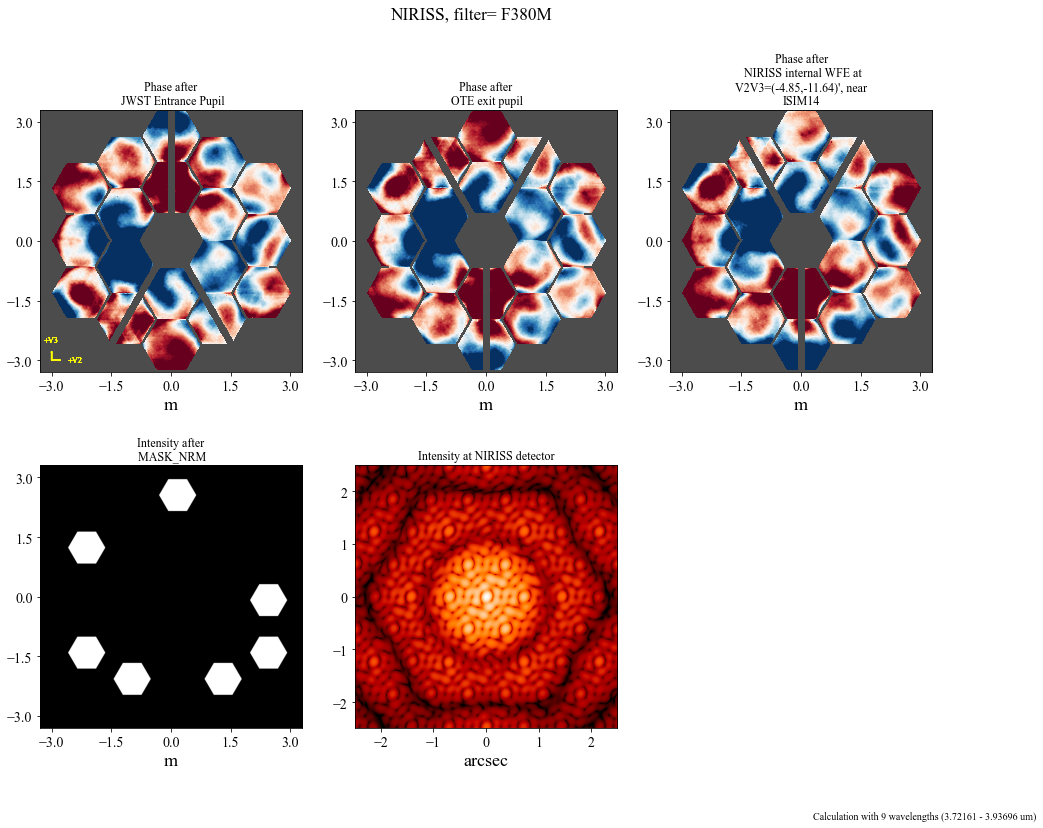

In [119]:
plt.figure(figsize=(16, 12))
out = niriss.calc_psf(display=True)

In [233]:
optsys = niriss.get_optical_system(fft_oversample=3, fov_arcsec=3)

<AxesSubplot:title={'center':'Intensity at NIRISS detector'}, xlabel='arcsec'>

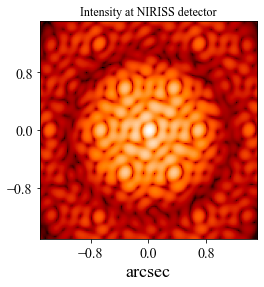

In [234]:
webbpsf_out, webbpsf_intermediates = optsys.propagate(optsys.input_wavefront(3.8e-6), return_intermediates=True)
webbpsf_out.display()

In [235]:
morphine_niriss = morphine.OpticalSystem(name="ami_niriss")

# entrance pupil
morphine_niriss.add_pupil(morphine.ArrayOpticalElement(
    transmission=optsys.planes[0].amplitude,
    opd=optsys.planes[0].opd,
    pixelscale=optsys.planes[0].pixelscale,
    name=optsys.planes[0].name,
    oversample=optsys.planes[0].oversample
))

morphine_niriss.add_inversion(index=1, axis="y", name=optsys.planes[1].name)

# JWST internal WFE error
morphine_niriss.add_pupil(morphine.ArrayOpticalElement(
    transmission=optsys.planes[2].amplitude,
    opd=optsys.planes[2].opd,
    pixelscale=optsys.planes[2].pixelscale,
    name=optsys.planes[2].name,
    oversample=optsys.planes[2].oversample
))
# NRM
morphine_niriss.add_pupil(morphine.ArrayOpticalElement(
    transmission=optsys.planes[3].amplitude,
    opd=optsys.planes[3].opd,
    pixelscale=optsys.planes[3].pixelscale,
    name=optsys.planes[3].name,
    oversample=optsys.planes[3].oversample
))

morphine_niriss.add_detector(
    pixelscale=optsys.planes[-1].pixelscale.value, # does not support astropy units
    fov_arcsec=optsys.planes[-1].fov_arcsec.value,
    oversample=optsys.planes[-1].oversample,
    name=optsys.planes[-1].name
);

In [236]:
morphine_niriss.describe()

	Pupil plane: JWST Entrance Pupil 
	Coordinate Inversion in y axis
	Pupil plane: NIRISS internal WFE at V2V3=(-4.85,-11.64)', near ISIM14 
	Pupil plane: MASK_NRM 
	Detector plane: NIRISS detector (46x46 pixels, 0.066)


In [237]:
optsys.describe()

	Pupil plane: JWST Entrance Pupil 
	Coordinate Inversion in y axis
	Pupil plane: NIRISS internal WFE at V2V3=(-4.85,-11.64)', near ISIM14 
	Pupil plane: MASK_NRM 
	Detector plane: NIRISS detector (46x46 pixels, 0.066 arcsec / pix)


In [241]:
morphine_out, morphine_intermediates = morphine_niriss.propagate(morphine_niriss.input_wavefront(3.8e-6), return_intermediates=True)

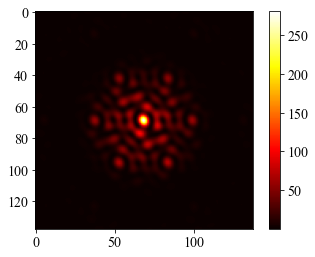

In [242]:
plt.imshow(morphine_out.intensity, cmap="hot")
plt.colorbar()

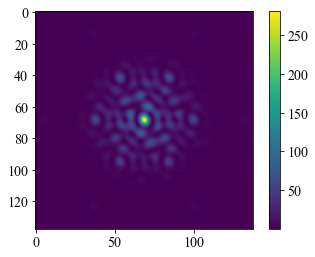

In [243]:
plt.imshow(webbpsf_out.intensity)
plt.colorbar()

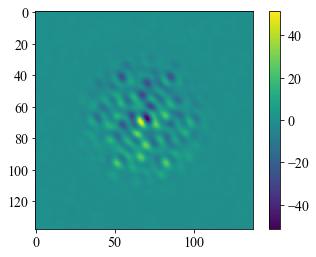

In [244]:
plt.imshow(morphine_out.intensity - webbpsf_out.intensity)
plt.colorbar()

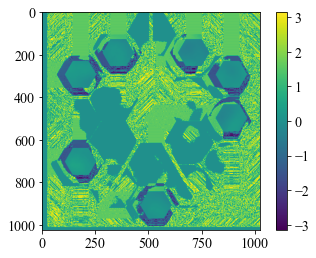

In [245]:
plt.imshow(morphine_intermediates[3].phase)
plt.colorbar()

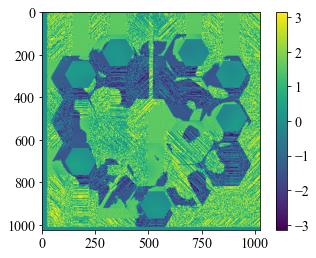

In [246]:
plt.imshow(webbpsf_intermediates[3].phase)
plt.colorbar()

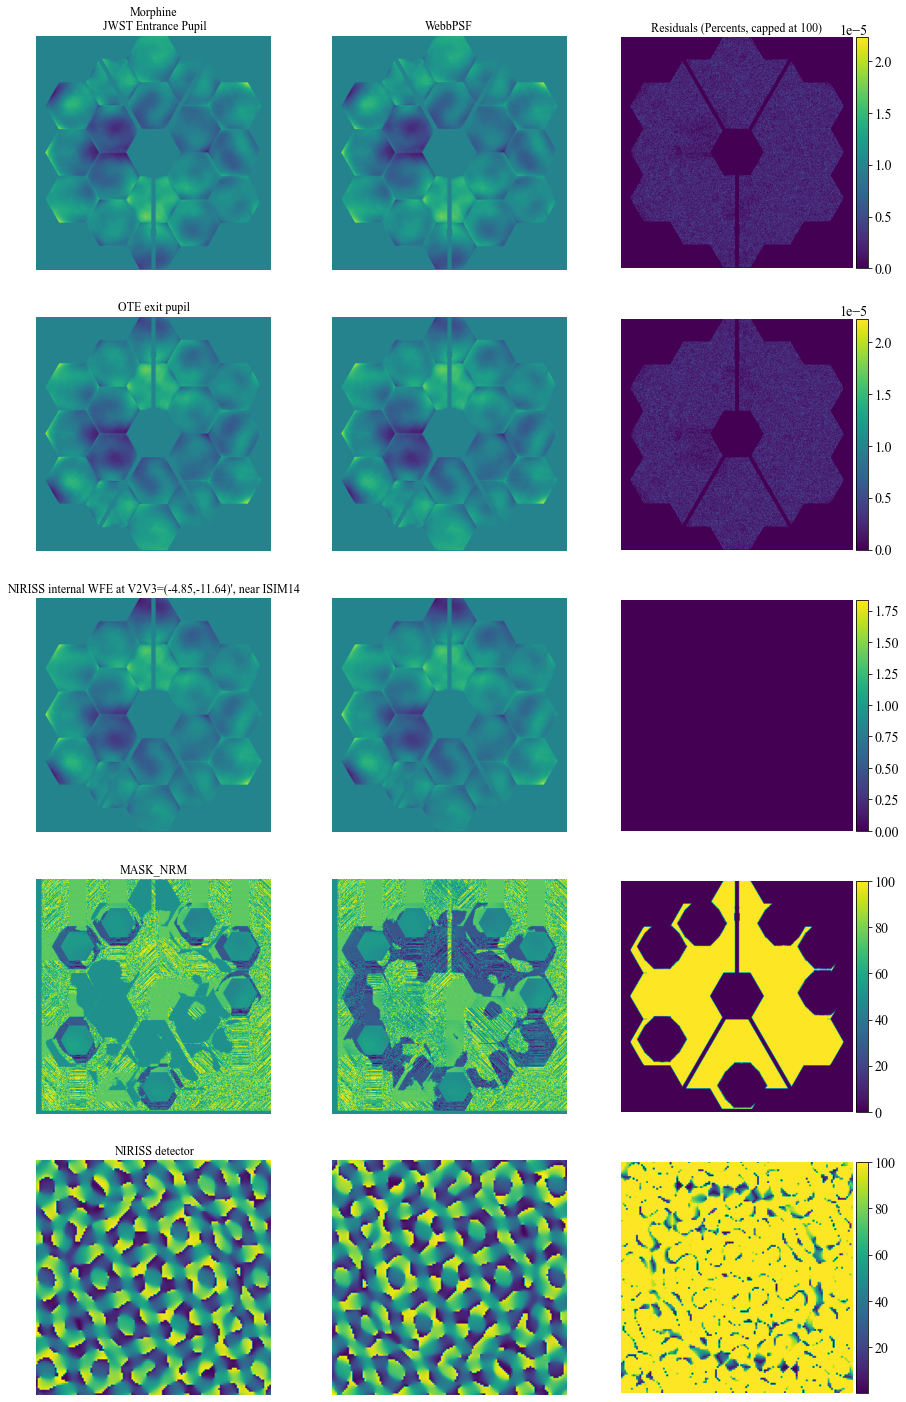

In [252]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
x = [morphine_intermediates[i].phase for i in range(5)]
y = [webbpsf_intermediates[i].phase for i in range(5)]
residuals = [np.minimum(np.abs((x[i] - y[i])/(np.abs(y[i])+1e-16))*100, np.ones_like(x[i])*100) for i in range(5)]
titles = ["Morphine", "WebbPSF", "Residuals (Percents, capped at 100)"]
images = [x, y, residuals]
for i in range(5):
    for j in range(3):
        im = axs[i, j].imshow(images[j][i])
        axs[i, j].axis("off")
        if i == 0:
            if j == 0:
                axs[i, j].set_title(f"{titles[j]}\n {morphine_niriss.planes[i].name}")
            else:
                axs[i, j].set_title(f"{titles[j]}")
        elif j == 0:
            axs[i, j].set_title(f"{morphine_niriss.planes[i].name}")
        if j == 2:
            divider = make_axes_locatable(axs[i, j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
plt.savefig("morphine_webbpsf_phase_comparison.png")

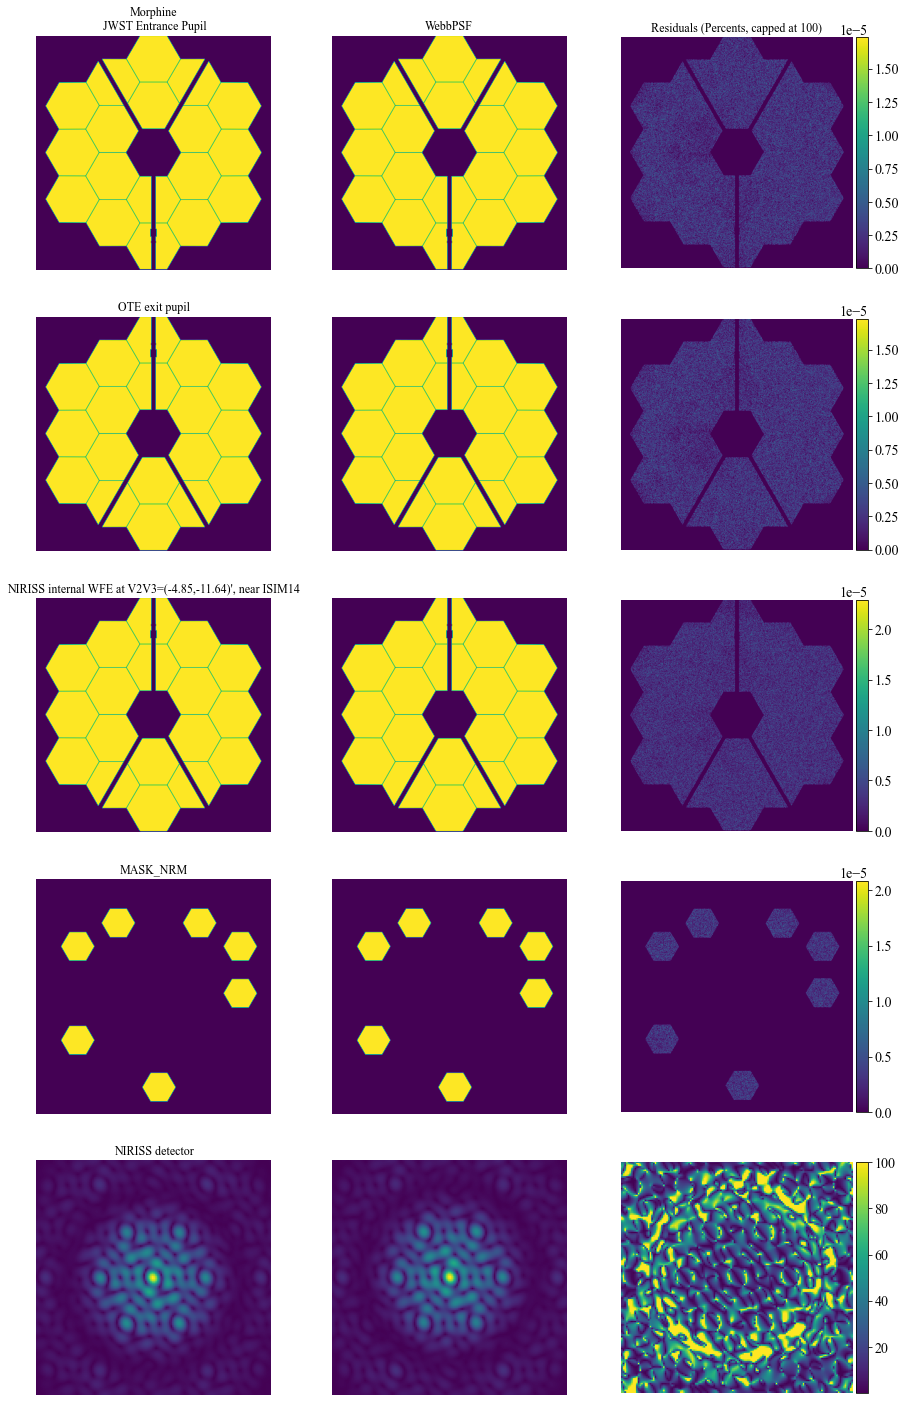

In [253]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
x = [morphine_intermediates[i].amplitude for i in range(5)]
y = [webbpsf_intermediates[i].amplitude for i in range(5)]
residuals = [np.minimum(np.abs(x[i] - y[i])/(y[i]+1e-16)*100, np.ones_like(x[i])*100) for i in range(5)]
titles = ["Morphine", "WebbPSF", "Residuals (Percents, capped at 100)"]
images = [x, y, residuals]
for i in range(5):
    for j in range(3):
        im = axs[i, j].imshow(images[j][i])
        axs[i, j].axis("off")
        if i == 0:
            if j == 0:
                axs[i, j].set_title(f"{titles[j]}\n {morphine_niriss.planes[i].name}")
            else:
                axs[i, j].set_title(f"{titles[j]}")
        elif j == 0:
            axs[i, j].set_title(f"{morphine_niriss.planes[i].name}")
        if j == 2:
            divider = make_axes_locatable(axs[i, j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
plt.savefig("morphine_webbpsf_amplitude_comparison.png")